In [16]:
!pip install --upgrade gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 97 kB 5.9 MB/s             
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=8383cf805b63f9cbfab5127f2324a00c1519463be548522eca22686a00882843
  Stored in directory: /home/kotech/.cache/pip/wheels/2b/3c/51/52c46deda5cd1d59c6ce3d441ea5f3d155495dc294c4535a25
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.0.2
    Uninstalling gdown-4.0.2:
      Successfully uninstalled gdown-4.0.2


# 2번과제 - Latent 공간에서의 Smiling 벡터 적용하기 (33점)

**템플릿**

Computing MD5: vae_weights.tar.gz
MD5 matches: vae_weights.tar.gz
weights/
weights/keras_metadata.pb
weights/checkpoint.data-00000-of-00001
weights/checkpoint.index
weights/variables/
weights/variables/variables.data-00000-of-00001
weights/variables/variables.index
weights/saved_model.pb
weights/checkpoint
weights/assets/


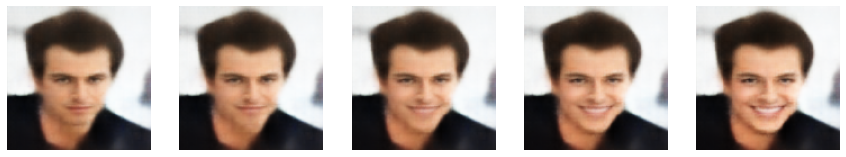

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from glob import glob
import gdown
import matplotlib.pyplot as plt

# image_file, z_start, z_end 값을 `12_deepfake.ipynb`실습 실행 부분에서 복사하여 업데이트 합니다.
image_file = '008629.jpg'
z_start = np.array([ 0.51165247  , -1.1973262   , -0.18806714  ,  0.3593927   ,
       -0.9896692   ,  0.045576066 , -2.888544    ,  1.4802008   ,
       -0.2041829   , -1.1171055   ,  0.5371562   ,  0.42627877  ,
       -1.2309686   , -2.0550058   , -0.7537902   , -0.07680813  ,
        2.0452733   , -1.1311386   , -0.46550226  ,  1.5755489   ,
        0.58928674  ,  1.1791966   ,  0.94917655  ,  0.5987749   ,
        0.5815001   ,  0.28586265  ,  0.06696689  ,  0.9477665   ,
        1.8414605   ,  1.9119034   ,  1.0567036   ,  0.3615513   ,
       -0.4104105   , -0.59189254  ,  1.2174647   ,  0.9946472   ,
        0.5241927   ,  2.1389232   , -0.51414186  , -0.7504797   ,
       -0.19267002  ,  1.0049567   ,  0.006421149 ,  0.82332313  ,
       -1.2039635   ,  0.4026336   ,  0.59752977  , -0.6505483   ,
       -0.14467421  , -1.1081607   , -1.0387355   ,  0.22033802  ,
        1.2906396   , -0.7465883   , -1.3119192   ,  1.8650314   ,
        0.7424985   ,  0.11610429  ,  0.53767824  ,  0.53099585  ,
       -0.062205195 , -0.43539634  , -0.49824527  ,  2.2648535   ,
        2.1154332   , -1.6803362   , -0.3174094   , -1.7905765   ,
        0.9095981   , -0.9161087   , -1.2652929   ,  1.1605979   ,
        1.5348216   ,  0.41232628  ,  0.008829355 ,  0.9567587   ,
       -0.8195963   , -2.156269    , -2.6899538   ,  0.89053595  ,
        0.83673096  , -1.840965    , -0.633362    ,  1.0299332   ,
       -1.9534174   , -0.85963917  , -0.20637904  ,  2.2067776   ,
       -0.21448427  ,  0.7314191   ,  1.7930303   ,  0.4430193   ,
       -0.7764752   ,  0.22775775  , -3.3790393   , -1.9394097   ,
       -1.1407137   ,  0.48087054  ,  1.0355675   ,  2.1436706   ,
        0.0357095   ,  0.47831464  , -0.17529714  ,  1.6886916   ,
       -0.60205996  , -2.149939    , -0.0059643984, -1.1478593   ,
        0.54694295  ,  2.3754637   , -0.31710178  ,  0.5101158   ,
        3.7773082   , -2.9317229   ,  1.9140741   ,  2.9450448   ,
        1.1843758   , -0.42405456  ,  1.2523038   ,  1.0985551   ,
       -1.1079183   , -0.9630812   , -0.18411824  ,  1.7597651   ,
        1.8354247   , -1.2998254   ,  1.515741    , -0.42342514  ,
        0.24223435  , -0.018041998 , -0.6703321   , -0.25324938  ,
       -1.5229226   , -0.82424057  ,  1.5374343   ,  0.9183435   ,
        0.77907187  , -0.6780119   ,  0.5217359   ,  0.38324603  ,
        1.038603    ,  0.79478425  ,  0.4412514   , -0.7481872   ,
        0.07701512  , -0.36489725  , -0.057156853 ,  0.3818175   ,
       -0.38217247  , -1.7098536   , -1.6881626   ,  0.99543333  ,
        1.6156795   , -0.24023664  , -0.7471294   ,  0.4793784   ,
        0.24937457  ,  0.12624429  , -1.4913517   , -0.73625934  ,
        0.5789245   , -0.5684443   , -0.72188705  ,  0.12764175  ,
       -2.6191442   ,  0.700166    ,  0.39041132  ,  0.08008385  ,
       -0.37719724  , -1.0280637   ,  0.21381554  ,  0.07182546  ,
        1.173063    ,  0.23851879  , -1.134413    ,  0.628986    ,
       -1.6083932   , -0.7461231   ,  0.13498461  ,  0.32760397  ,
        0.8181643   , -2.3889465   , -0.030497007 , -0.07983138  ,
        0.5969469   ,  0.61000985  ,  1.461432    , -0.3340329   ,
        1.7357419   ,  0.49665862  ,  0.47224945  ,  0.75099295  ,
        2.3244333   ,  0.3104105   ,  1.5840006   , -0.053501666 ,
       -1.2293062   , -1.2836668   ,  3.0475667   ,  0.2972155   ],
      dtype='float32')
z_end = np.array([ 5.72977960e-01, -1.17467523e+00, -1.95226938e-01,  2.44418800e-01,
       -1.07260275e+00, -3.16603482e-02, -3.04139423e+00,  1.54305375e+00,
       -1.64888859e-01, -8.53234768e-01,  4.66521442e-01,  3.83821785e-01,
       -1.43313909e+00, -1.87543082e+00, -4.99349624e-01, -1.70870394e-01,
        1.77098560e+00, -1.21392393e+00, -4.80084658e-01,  1.64434516e+00,
        1.88662839e+00,  1.13736928e+00, -1.17789865e-01,  5.08254766e-01,
        5.75029373e-01,  3.71077269e-01,  1.09070159e-01,  1.00230491e+00,
        1.69477463e+00,  1.94024813e+00,  1.07472181e+00,  2.08851844e-01,
       -4.09724802e-01, -5.65167069e-01,  1.23436999e+00,  4.20415044e-01,
        4.03792560e-01,  2.17169404e+00, -5.13979256e-01, -7.00644433e-01,
       -4.12017405e-01,  9.01915193e-01,  4.75870430e-01,  8.44886363e-01,
       -1.25241423e+00,  4.50602233e-01,  6.26643658e-01, -6.78528130e-01,
       -5.26039004e-01, -7.46038795e-01, -7.62022972e-01,  2.15544313e-01,
        3.76785815e-01, -5.60305238e-01, -1.29251766e+00,  1.88069797e+00,
        6.80058718e-01, -7.69171864e-03,  5.51092267e-01,  5.25287628e-01,
       -1.20652840e-03, -4.22662735e-01, -3.14550579e-01,  2.87449431e+00,
        1.78322077e+00, -2.02736044e+00, -2.50060737e-01, -1.69495666e+00,
        8.50703776e-01, -8.20137918e-01, -1.39862287e+00,  1.12130570e+00,
        1.63355219e+00,  1.56464845e-01,  2.28159390e-02,  1.48026490e+00,
       -7.36107945e-01, -2.69309950e+00, -2.67915940e+00,  9.00430441e-01,
        8.59273136e-01, -1.87040365e+00, -5.33185482e-01,  9.74141240e-01,
       -2.00012422e+00, -8.29578996e-01, -4.01541889e-01,  2.28007412e+00,
       -2.36341104e-01,  6.12758756e-01,  1.82076514e+00,  5.61124325e-01,
       -8.30627978e-01,  3.54324281e-01, -2.40655708e+00, -1.78879988e+00,
       -1.16929054e+00,  4.51794624e-01,  4.65384901e-01,  2.12182879e+00,
        3.66598874e-01,  2.29912758e-01, -3.13030750e-01,  1.51989603e+00,
       -3.05434644e-01, -2.09333229e+00, -2.84276865e-02, -1.11931121e+00,
        4.25237447e-01,  2.52315187e+00, -2.79049665e-01,  3.10506999e-01,
        3.65646696e+00, -2.84021711e+00,  1.77909219e+00,  2.54825330e+00,
        1.07033658e+00,  1.03108704e-01,  1.32091248e+00,  1.03996384e+00,
       -2.13494015e+00, -8.67035031e-01, -1.26776934e-01,  1.75396907e+00,
        1.07416964e+00, -1.34220207e+00,  1.65193868e+00, -4.75422591e-01,
        1.55517697e-01, -1.14617862e-01, -6.67772591e-01, -3.13118905e-01,
       -1.39692926e+00, -8.44218612e-01,  2.50200295e+00,  9.17499244e-01,
        7.17299461e-01, -1.70274711e+00,  6.24216914e-01,  4.03311908e-01,
        6.48391664e-01,  8.70243251e-01,  4.31221575e-01,  2.20583677e-02,
        1.71008140e-01, -3.80540580e-01, -1.39102489e-01,  3.67843717e-01,
       -7.73660719e-01, -1.74468589e+00, -1.73297906e+00,  1.03721666e+00,
        1.66422296e+00, -7.99888730e-01, -1.00115657e+00,  4.83160436e-01,
        2.40218386e-01,  3.61453891e-02, -1.24380159e+00, -1.15480435e+00,
        6.45831466e-01, -3.64400446e-01, -6.47031784e-01,  3.84977460e-02,
       -2.63333535e+00,  5.28283715e-01,  3.88369769e-01,  7.97789097e-02,
       -4.78187680e-01, -9.69784558e-01,  1.41845986e-01,  1.58796579e-01,
        1.13848770e+00,  2.02747107e-01, -8.36311102e-01,  5.71853220e-01,
       -1.48306406e+00, -6.87719882e-01, -1.65692091e-01,  2.45054603e-01,
        7.54548907e-01, -3.58206987e+00, -9.21691954e-02,  1.52216822e-01,
        5.73537290e-01,  6.43846810e-01,  1.43375707e+00, -3.37227434e-01,
        1.85679078e+00,  4.50727373e-01,  4.55063194e-01,  8.84635687e-01,
        2.12412310e+00,  4.25927699e-01,  1.81570625e+00, -6.59308583e-02,
       -1.15431726e+00, -1.32918453e+00,  2.89771724e+00,  2.50184685e-01],
      dtype='float32')


INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

md5 = 'b387a8f59bd8bc09ee1eb12a80294379'  
url = 'https://drive.google.com/uc?id=19m6cQVNqXRhD6iEGkjA8ZZcOdev_b2V1'
output = 'vae_weights.tar.gz'

gdown.cached_download(url, output, md5=md5)

!mkdir -p vae_data
!tar xvzf vae_weights.tar.gz -C vae_data

class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(log_var/2) * epsilon

z_dim = 200
r_loss_factor = 10000

encoder_input = keras.Input(shape=INPUT_DIM, name='encoder_input')
x = Conv2D(32, 3, strides=2, padding="same", name='encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')

decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t0')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": tf.reduce_mean(total_loss),
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),
            "kl_loss": tf.reduce_mean(kl_loss),
        }

    def call(self,inputs):
        _,_,latent = self.encoder(inputs)
        return self.decoder(latent)

VAE = VAEModel(encoder, decoder)
LEARNING_RATE = 0.0005
VAE.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

SAVE_FOLDER = 'vae_data'
save_folder = os.path.join(SAVE_FOLDER, 'weights')
VAE.load_weights(save_folder+'/'+'checkpoint')

smiling_vec = (z_end - z_start)/4
factors = [0,1,2,3,4]
fig = plt.figure(figsize=(18, 10))
for counter, factor in enumerate(factors):
    changed_z_point = z_start + smiling_vec * factor
    changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]
    img = changed_image.squeeze()
    sub = fig.add_subplot(1, len(factors) + 1, 1+counter)
    sub.axis('off')
    sub.imshow(img)


#  z텐서의 배열 내에 `attribute==1` 혹은 `attribute==-1`라는 boolean tensor를 입력하였습니다.  
#  텐서의 배열에 boolean tensor를 넣으면 역할을 하는지 각자 공부해 보고 그 역할에 대해 `ans06`에 기입합니다. 
ans06 = """
여기에 기입하세요.
"""

# `np.sum(z_POS, axis = 0)` 합계를 할 때에 `axis=0`을 주었습니다.
#  그 이유에 대해 생각해보고 `ans07`에 기입합니다.  
ans07 = """
여기에 기입하세요.
"""

#  `if np.sum([movement_POS, movement_NEG]) < 0.08:` 이 조건을 만족시키면 평균 계산 루프가 중단되도록 되어 있습니다.  
#  이 조건은 어떤 의미인지 `ans08`에 기입합니다. 
ans08 = """
여기에 기입하세요.
"""

ans09 = image_file
ans10 = z_start.copy()
ans11 = z_end.copy()

**과제 내용**

이번 과제는 13주차 실습에 진행하였던, `12_deepfake.ipynb`에서 latent vector를 움직여서 얼굴의 특징을 변화시키는 내용입니다.  

이 과제를 통하여, VAE의 소스코드를 조금 더 자세하게 이해하게 될 것입니다.

1. `12_deepfake.ipynb`실습 파일을 열어서, 처음부터 차근차근 수행합니다.  
   중간에 **Training** cell은 실행하다가 중지해 주십시오. (미리 학습된 weights를 불러와서 진행하기 때문입니다.)  
   `def add_vector_to_images(feature_vec):`가 정의된 cell까지 실행해 주십시오.
    
   다음 cell은 평균 vector를 추출하는 부분입니다.
   eyeglasses_vec를 구하는 부분을 comment out하고, smiling_vec를 구하는 부분을 수행하도록 변경합니다. 
   ```python
   BATCH_SIZE = 500
   # attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
   # mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
   smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
   # lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
   # young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
   # male_vec = get_vector_from_label('Male', BATCH_SIZE)
   # eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
   # blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)
   ```
   위와 같은 코드로 수정후에 실행합니다.  
   Latent 공간에서 `Smiling` 벡터를 계산하고 산출합니다.  
    
    
2. `ImageLabelLoader()`함수를 읽고 이해합시다.  
   함수내에서 keras의 DataLoader 함수가 호출됩니다.  
   DataLoader는 대용량의 학습데이터를 읽어들이는 모듈의 기본 형식 중 하나입니다.  
   keras학습에서 자주 사용되므로, 많이 사용해보고 익숙해 질 필요가 있습니다. 
   학습 데이터의 크기가 대용량이 되면, 거의 대부분 DataLoader의 형식으로 읽어서 `model.fit()`에 입력으로 사용합니다.  
   학습이 진행되는 동안 GPU가 사용될 때, 남는 CPU자원을 활용하여 미리 데이터를 읽어서 학습 속도를 향상시키는 기능등으로 확장 가능하기 때문입니다.  
   (이번 VAE에서는 이러한 prefetch의 기능은 사용하지 않았습니다.)  
    
   함수내의 `flow_from_dataframe()` 라이브러리에 대해 학습합시다.  
   https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe  
    
   `ImageLabelLoader()`함수는 두 종류로 데이터를 생성할 수 있도록 준비되어 있습니다. `build`시에 `label`을 지정하거나, 지정하지 않거나 할 경우 입니다.  
   `label` 지정시에, `y_col=label`로서, CSV파일의 해당 column을 y값으로 반환합니다. 이 경우 `class_mode='raw'`를 이용합니다.  
   이렇게 되면 한 batch의 데이터를 loading하게 되면, 
   ```python
   data_flow_label = imageLoader.build(att, batch_size, label = label)
   batch = next(data_flow_label) # 한 배치를 추출해서 가져옴.
   ```
   `batch[0]`에는 이미지의 batch 데이터가, `batch[1]`에는 해당 칼럼의 속성값의 batch가 들어오게 됩니다.  
   이렇게 준비한 데이터는 latent 공간에서 특징 벡터를 추출하는 `get_vector_from_label()`에서 사용됩니다.  
   
   `label` 미지정시에는 `class_mode='input'`을 이용하고, 이 경우 `batch[0]`, `batch[1]` 모두 이미지 batch 데이터가 들어있습니다. 
   실습 파일에서는 무작위로 이미지를 불러오는 부분에서 사용하였습니다.  
    
    
3. 실습파일에서 `get_vector_from_label()` 함수의 정의를 읽어보고 분석합니다.  
   `label`에 속성 column명이 지정되었을 경우, 해당 속성과 해당 속성이 없는 것을 분류하고 각각의 latent vector의 평균을 구한 후에,
   두 평균 vector의 차이를 구하는 함수입니다. 
   해당 속성이 있는 것을 positive(`POS`), 없는 것을 negative(`NEG`)라고 변수명에 postfix로 사용하고 있습니다.  
   
   먼저 충분한 갯수만큼 loop가 수행됩니다. 
   ```python
   while(current_n_POS < 10000):
   ```
   다음은 이미지와 속성을 한 batch만큼 가져오는 DataLoader 부분입니다.
   ```python
   batch = next(data_flow_label)
   im = batch[0]
   attribute = batch[1]
   ```
   이제 이미지로부터 latent vector $z$를 출력합니다.  
   ```python
   _,_,z = vae.encoder.predict(np.array(im))
   ```
   다음은 z의 batch로부터 attribute가 positive인 경우와 negative인 경우로 데이터를 분리하는 모듈입니다.
   ```python
   z_POS = z[attribute==1]
   z_NEG = z[attribute==-1]
   ```
   z텐서의 배열 내에 `attribute==1` 혹은 `attribute==-1`라는 boolean tensor를 입력하였습니다.  
   텐서의 배열에 boolean tensor를 넣으면 역할을 하는지 각자 공부해 보고 그 역할에 대해 `ans06`에 기입합니다.
    
   다음 부분은 계속해서 `POS`와 `NEG` 속성의 latent vector z를 계속 더하고 그 갯수를 기록해서 평균값을 계산할 수 있도록 합니다.
   ```python
   if len(z_POS) > 0:
       current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
       current_n_POS += len(z_POS)
       new_mean_POS = current_sum_POS / current_n_POS
       movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

   if len(z_NEG) > 0: 
       current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
       current_n_NEG += len(z_NEG)
       new_mean_NEG = current_sum_NEG / current_n_NEG
       movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)
   ```
   여기서 `np.sum(z_POS, axis = 0)` 합계를 할 때에 `axis=0`을 주었습니다.
   그 이유에 대해 생각해보고 `ans07`에 기입합니다.  
   `if np.sum([movement_POS, movement_NEG]) < 0.08:` 이 조건을 만족시키면 평균 계산 루프가 중단되도록 되어 있습니다.  
   이 조건은 무엇을 의미하는지 `ans08`에 기입합니다.  
    
   최종적으로 두 평균벡터의 차이를 계산한 후에 벡터를 normalize합니다. (길이가 1이되도록 만듭니다.)  
   ```python
   current_vector = current_vector / current_dist
   ```
   우리가 두 속성 차이 벡터의 방향만 알 수 있고, 그 절대 크기를 알 수 없으므로 latent vector에 이것을 가감할때에,  
   적당한 factor를 곱해주면서 테스트 해 보아야 합니다.  
    
    
4. 입력 이미지의 latent vector에 속성 vector를 더하는 함수  
   기존의 `add_vector_to_images()`함수를 약간 변형하여 `add_vector_to_images2()`함수를 만들었습니다.  
   ```python
   def add_vector_to_images2(feature_vec):
       n_to_show = 5
       factors = [0,1,2,3,4]

       example_batch = next(data_flow_generic)
       example_images = example_batch[0]
       example_labels = example_batch[1]

       _,_,z_points = vae.encoder.predict(example_images)

       fig = plt.figure(figsize=(18, 10))

       counter = 1
       for i in range(n_to_show):
           img = example_images[i].squeeze()
           sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
           sub.axis('off')        
           sub.imshow(img)

           counter += 1

           for factor in factors:
               changed_z_point = z_points[i] + feature_vec * factor
               changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

               img = changed_image.squeeze()
               sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
               sub.axis('off')
               sub.imshow(img)

               counter += 1
       plt.show()
       return z_points  
    
   print('Smiling Vector')
   z_points = add_vector_to_images2(smiling_vec)  

   idx = (data_flow_generic.batch_index - 1) * data_flow_generic.batch_size
   idx_list = data_flow_generic.index_array[idx : idx + 5].tolist()
   image_file_name = [data_flow_generic.filenames[j] for j in idx_list]
   ```
    
   변경점은 factor를 -4부터 4까지 변화시키는 것이아니라 0부터 4까지만 변화시키도록 하였습니다.  
   그리고 z_points를 출력하여, latent 벡터의 값 자체를 확인할 수 있도록 하였습니다.  
   실습 파일에 위 cell을 추가하고 실행해 봅시다.  
    
   무작위로 다섯개의 원본이미지와 그 이미지의 latent vector에 smiling vector를 더한 이미지를 출력하도록 하였습니다.  
   마음에 드는 이미지의 변화가 나타났나요?  
   혹시 마음에 들지 않으면 몇 번 더 cell을 재실행하면서 확인합시다.  
   5개 중에 마음에 드는 이미지 번호를 선택합니다. (0번, 1번, 2번, 3번, 4번 중에 선택)  
   먼저 맨 왼쪽의 원본이미지가 무표정이고 맨 오른쪽의 변화된 이미지가 웃는 얼굴이면 OK입니다.  
   (얼굴은 여러분들의 취향이니, 여러분이 마음에 드는 이미지로 선택합시다.)  
   
   다시 cell을 추가하고 다음의 코드를 선택합니다. 변수 `i`에는 여러분이 선택한 번호를 입력합니다. (0,1,2,3,4 중에 선택)  
   코드는 단순히 선택이 맞았는 지를 이미지 출력으로 확인하는 것에 불과합니다.
   
   ```python
   i = 0 # 몇번째 그림인지 선택하세요 0,1,2,3,4 중에 번호를 변경하세요.

   # 여러분이 선택한 이미지가 맞는 지 확인하세요.
   factors = [0,1,2,3,4]
   img = plt.imread('./vae_data/celeb/img_align_celeba/%s'%image_file_name[i])
   fig = plt.figure(figsize=(18, 10))
   sub = fig.add_subplot(1, len(factors) + 1, 1)
   sub.axis('off')        
   sub.imshow(img)
   for counter, factor in enumerate(factors):
       changed_z_point = z_points[i] + smiling_vec * factor
       changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]
       img = changed_image.squeeze()
       sub = fig.add_subplot(1, len(factors) + 1, 2+counter)
       sub.axis('off')
       sub.imshow(img)
   ```

   선택이 끝나셨으면, cell을 다시 추가하고 다음의 코드를 실행합니다.
   
   ```python
   print("image_file = '%s'"%image_file_name[i])
   z = z_points[i]
   z_start_str = 'z_start = np.'+repr(z).replace("float32", "'float32'")
   print(z_start_str)
   z_end_str = 'z_end = np.'+repr(z+4*smiling_vec).replace("float32", "'float32'")
   print(z_end_str)
   ```
   원본이미지 파일의 번호와 시작 latent vector, 끝 latent vector를 출력하는 코드입니다.  
   출력 결과를 메모장에 복사하십시오.  
   여기까지 수행하셨으면, `12_deepfake.ipynb`실습파일은 종료하셔도 됩니다.  
    
    
5. 템플릿을 과제 기입란에 복사한 후에, 메모장에 복사해두었던 코드로 해당 데이터를 업데이트 하십시오.  
   템플릿의 코드는 실습파일의 VAE Model과 거의 동일합니다.
   코드가 수정되면, 실행해서 동일한 얼굴이 생성되는 지 확인하세요.  
   `image_file`과 `z_start`, `z_end`값을 `ans09`, `ans10`, `ans11`에 기록합니다. (이미 템플릿 코드에 포함되어 있습니다.)  
   
   
6. 우리는 무엇을 얻었습니까?  

   먼저 실습 노트북과, 과제 코드에서 공유된 것은 Model과 그 weights(학습 저장 데이터)입니다.  
   그 이외에는 z_start, z_end의 두 latent vector를 전달하였습니다.  
   이것으로 두 노트북사이에 시작과 끝 두 개의 이미지를 다시 생성할 수 있습니다.  
   
   생성된 이미지는 (128,128,3)의 shape입니다. 이 데이터는 약 50KB입니다. 
   이 이미지를 JPEG으로 압축하더라도 약 3KB의 용량이 됩니다.  
   하지만 전달된 데이터는 float32(4byte) 200개입니다. 총 800byte 입니다.  
   얼굴 데이터 셋만을 대상으로 하였을 경우에는 압도적으로 적은 데이터로 얼굴 영상을 전달하였습니다.  
   Autoencoder 혹은 Variational Autoencoder의 encoder와 decoder는 각각 영상의 압축 및 해제와 비슷한 기능을 한다고 하겠습니다.  
   두 개의 이미지를 가지고 중간 이미지도 재생성 할 수 있다는 것은 보너스입니다.  
   
   모두들 무뚝뚝한 얼굴 이미지를 웃는 얼굴 이미지로 바꾸는데 성공하셨나요?  
   여러분의 앞날에도 항상 웃음이 가득하길 기원합니다.  

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [6]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=False)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /home/kotech/workspace/webstudy/deep/exam/celeba_gan/data.zip
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.44G/1.44G [02:14<00:00, 10.8MB/s]


In [7]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


2021-11-24 16:46:49.638418: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-24 16:46:50.152190: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2021-11-24 16:46:50.152230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14025 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:b5:00.0, compute capability: 8.6


2021-11-24 16:46:50.409180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


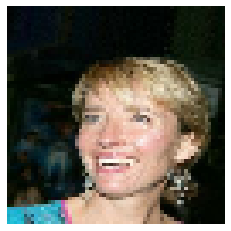

In [8]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [9]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [10]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

In [13]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [14]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [15]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100


2021-11-24 16:47:19.312224: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-11-24 16:47:19.808676: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


6332/6332 [==============================] - 365s 57ms/step - d_loss: 0.6050 - g_loss: 1.2797
Epoch 2/100
6332/6332 [==============================] - 363s 57ms/step - d_loss: 0.6486 - g_loss: 1.1013
Epoch 3/100
6332/6332 [==============================] - 363s 57ms/step - d_loss: 0.6583 - g_loss: 1.0592
Epoch 4/100
6332/6332 [==============================] - 363s 57ms/step - d_loss: 0.6464 - g_loss: 1.0714
Epoch 5/100
6332/6332 [==============================] - 363s 57ms/step - d_loss: 0.6453 - g_loss: 1.0465
Epoch 6/100
6332/6332 [==============================] - 363s 57ms/step - d_loss: 0.6572 - g_loss: 0.9781
Epoch 7/100
6332/6332 [==============================] - 363s 57ms/step - d_loss: 0.6666 - g_loss: 0.9482
Epoch 8/100
6332/6332 [==============================] - 363s 57ms/step - d_loss: 0.6720 - g_loss: 0.9219
Epoch 9/100
6332/6332 [==============================] - 361s 57ms/step - d_loss: 0.6747 - g_loss: 0.9192
Epoch 10/100
6332/6332 [==============================] - 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4233/6332 [===================>..........] - ETA: 1:59 - d_loss: 0.6486 - g_loss: 0.9511

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 359s 57ms/step - d_loss: 0.6464 - g_loss: 0.9476
Epoch 26/100
1491/6332 [======>.......................] - ETA: 4:34 - d_loss: 0.6472 - g_loss: 0.9405

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5113/6332 [=======================>......] - ETA: 1:09 - d_loss: 0.6484 - g_loss: 0.9393

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 359s 57ms/step - d_loss: 0.6495 - g_loss: 0.9533
Epoch 31/100
2316/6332 [=========>....................] - ETA: 3:47 - d_loss: 0.6500 - g_loss: 0.9670

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5582/6332 [=========================>....] - ETA: 42s - d_loss: 0.6365 - g_loss: 0.9629

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 359s 57ms/step - d_loss: 0.6351 - g_loss: 0.9699
Epoch 36/100
  54/6332 [..............................] - ETA: 5:55 - d_loss: 0.6094 - g_loss: 0.9911

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2411/6332 [==========>...................] - ETA: 3:42 - d_loss: 0.6373 - g_loss: 0.9777

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3269/6332 [==============>...............] - ETA: 2:53 - d_loss: 0.6320 - g_loss: 0.9873

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5715/6332 [==========================>...] - ETA: 34s - d_loss: 0.6305 - g_loss: 0.9881

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 359s 57ms/step - d_loss: 0.6252 - g_loss: 0.9859
Epoch 41/100
 234/6332 [>.............................] - ETA: 5:45 - d_loss: 0.6291 - g_loss: 0.9508

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2687/6332 [===========>..................] - ETA: 3:26 - d_loss: 0.6291 - g_loss: 1.0058

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3539/6332 [===============>..............] - ETA: 2:38 - d_loss: 0.6197 - g_loss: 0.9946

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5983/6332 [===========================>..] - ETA: 19s - d_loss: 0.6199 - g_loss: 0.9955

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 359s 57ms/step - d_loss: 0.6128 - g_loss: 1.0191
Epoch 46/100
 323/6332 [>.............................] - ETA: 5:40 - d_loss: 0.6044 - g_loss: 1.0349

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2935/6332 [============>.................] - ETA: 3:12 - d_loss: 0.6127 - g_loss: 1.0245

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3382/6332 [===============>..............] - ETA: 2:47 - d_loss: 0.6127 - g_loss: 1.0322

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5807/6332 [==========================>...] - ETA: 29s - d_loss: 0.6114 - g_loss: 1.0336

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.6101 - g_loss: 1.0376
Epoch 51/100
  65/6332 [..............................] - ETA: 5:54 - d_loss: 0.5850 - g_loss: 1.1186

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2672/6332 [===========>..................] - ETA: 3:27 - d_loss: 0.6107 - g_loss: 1.0279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4276/6332 [===================>..........] - ETA: 1:56 - d_loss: 0.6089 - g_loss: 1.0447

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3510/6332 [===============>..............] - ETA: 2:39 - d_loss: 0.6081 - g_loss: 1.0273

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.6066 - g_loss: 1.0336
Epoch 56/100
 937/6332 [===>..........................] - ETA: 5:05 - d_loss: 0.6057 - g_loss: 1.0795

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.6064 - g_loss: 1.0471
Epoch 58/100
 291/6332 [>.............................] - ETA: 5:41 - d_loss: 0.6031 - g_loss: 1.0614

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4218/6332 [==================>...........] - ETA: 1:59 - d_loss: 0.6019 - g_loss: 1.0542

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3214/6332 [==============>...............] - ETA: 2:56 - d_loss: 0.6030 - g_loss: 1.0599

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.6045 - g_loss: 1.0542
Epoch 61/100
 831/6332 [==>...........................] - ETA: 5:11 - d_loss: 0.6017 - g_loss: 1.0832

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.6020 - g_loss: 1.0597
Epoch 63/100
 149/6332 [..............................] - ETA: 5:50 - d_loss: 0.5972 - g_loss: 1.1188

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3908/6332 [=================>............] - ETA: 2:17 - d_loss: 0.6018 - g_loss: 1.0583

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3157/6332 [=============>................] - ETA: 2:59 - d_loss: 0.5991 - g_loss: 1.0592

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5988 - g_loss: 1.0615
Epoch 66/100
 789/6332 [==>...........................] - ETA: 5:13 - d_loss: 0.6001 - g_loss: 1.0802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5984 - g_loss: 1.0697
Epoch 68/100
  53/6332 [..............................] - ETA: 5:54 - d_loss: 0.5960 - g_loss: 1.1014

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3843/6332 [=================>............] - ETA: 2:20 - d_loss: 0.5967 - g_loss: 1.0798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3045/6332 [=============>................] - ETA: 3:05 - d_loss: 0.5960 - g_loss: 1.0777

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5949 - g_loss: 1.0756
Epoch 71/100
 695/6332 [==>...........................] - ETA: 5:18 - d_loss: 0.5925 - g_loss: 1.0873

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6202/6332 [============================>.] - ETA: 7s - d_loss: 0.5929 - g_loss: 1.0824

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3847/6332 [=================>............] - ETA: 2:20 - d_loss: 0.5936 - g_loss: 1.0774

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3057/6332 [=============>................] - ETA: 3:05 - d_loss: 0.5909 - g_loss: 1.0823

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5889 - g_loss: 1.0926
Epoch 76/100
 518/6332 [=>............................] - ETA: 5:28 - d_loss: 0.5874 - g_loss: 1.0859

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4155/6332 [==================>...........] - ETA: 2:03 - d_loss: 0.5870 - g_loss: 1.0875

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5870 - g_loss: 1.0874
Epoch 78/100
 928/6332 [===>..........................] - ETA: 5:05 - d_loss: 0.5848 - g_loss: 1.1135

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3719/6332 [================>.............] - ETA: 2:27 - d_loss: 0.5854 - g_loss: 1.1110

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 966/6332 [===>..........................] - ETA: 5:03 - d_loss: 0.5814 - g_loss: 1.1050

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4071/6332 [==================>...........] - ETA: 2:07 - d_loss: 0.5824 - g_loss: 1.1002

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5822 - g_loss: 1.1042
Epoch 81/100
 529/6332 [=>............................] - ETA: 5:27 - d_loss: 0.5809 - g_loss: 1.1187

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4160/6332 [==================>...........] - ETA: 2:02 - d_loss: 0.5791 - g_loss: 1.1245

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5791 - g_loss: 1.1277
Epoch 83/100
 763/6332 [==>...........................] - ETA: 5:14 - d_loss: 0.5742 - g_loss: 1.1267

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3725/6332 [================>.............] - ETA: 2:27 - d_loss: 0.5757 - g_loss: 1.1279

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 843/6332 [==>...........................] - ETA: 5:10 - d_loss: 0.5726 - g_loss: 1.1308

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3980/6332 [=================>............] - ETA: 2:12 - d_loss: 0.5738 - g_loss: 1.1420

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5733 - g_loss: 1.1406
Epoch 86/100
 402/6332 [>.............................] - ETA: 5:35 - d_loss: 0.5754 - g_loss: 1.1434

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4052/6332 [==================>...........] - ETA: 2:08 - d_loss: 0.5717 - g_loss: 1.1375

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5714 - g_loss: 1.1470
Epoch 88/100
 660/6332 [==>...........................] - ETA: 5:20 - d_loss: 0.5667 - g_loss: 1.1438

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3619/6332 [================>.............] - ETA: 2:33 - d_loss: 0.5714 - g_loss: 1.1402

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5671 - g_loss: 1.1539
Epoch 90/100
 753/6332 [==>...........................] - ETA: 5:15 - d_loss: 0.5652 - g_loss: 1.1471

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3869/6332 [=================>............] - ETA: 2:19 - d_loss: 0.5673 - g_loss: 1.1516

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 359s 57ms/step - d_loss: 0.5665 - g_loss: 1.1564
Epoch 91/100
 479/6332 [=>............................] - ETA: 5:31 - d_loss: 0.5625 - g_loss: 1.1448

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3938/6332 [=================>............] - ETA: 2:15 - d_loss: 0.5652 - g_loss: 1.1650

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5642 - g_loss: 1.1677
Epoch 93/100
 738/6332 [==>...........................] - ETA: 5:16 - d_loss: 0.5636 - g_loss: 1.1606

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3677/6332 [================>.............] - ETA: 2:30 - d_loss: 0.5643 - g_loss: 1.1723

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 358s 57ms/step - d_loss: 0.5613 - g_loss: 1.1723
Epoch 95/100
 791/6332 [==>...........................] - ETA: 5:12 - d_loss: 0.5614 - g_loss: 1.1723

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3737/6332 [================>.............] - ETA: 2:26 - d_loss: 0.5611 - g_loss: 1.1768

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 357s 56ms/step - d_loss: 0.5597 - g_loss: 1.1801
Epoch 96/100
 530/6332 [=>............................] - ETA: 5:27 - d_loss: 0.5573 - g_loss: 1.1933

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3813/6332 [=================>............] - ETA: 2:21 - d_loss: 0.5583 - g_loss: 1.1856

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 357s 56ms/step - d_loss: 0.5576 - g_loss: 1.1859
Epoch 98/100
 649/6332 [==>...........................] - ETA: 5:20 - d_loss: 0.5542 - g_loss: 1.2213

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3569/6332 [===============>..............] - ETA: 2:35 - d_loss: 0.5572 - g_loss: 1.1914

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 357s 56ms/step - d_loss: 0.5546 - g_loss: 1.1952
Epoch 100/100
 691/6332 [==>...........................] - ETA: 5:18 - d_loss: 0.5529 - g_loss: 1.2062

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3667/6332 [================>.............] - ETA: 2:30 - d_loss: 0.5511 - g_loss: 1.2023

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6332/6332 [==============================] - 357s 56ms/step - d_loss: 0.5505 - g_loss: 1.2034
